In [1]:

from IPython.utils import io
import json
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve
import sys
import torch
import torchvision.models as models

from Misc import get_pair

sys.path.insert(0, '../COCO/')
from COCOWrapper import COCOWrapper
from Dataset import ImageDataset, my_dataloader
from ModelWrapper import ModelWrapper

In [2]:


def evaluate(main, spurious, cop_with_main, cop_without_main, trial, root = '/home/gregory/Datasets/COCO', year = '2017', num_samples = 100):

    base = './Pairs/{}-{}/{}-{}/trial{}'.format(main, spurious, cop_with_main, cop_without_main, trial)
    
    # Get the 'testing' images
    with io.capture_output() as captured:
        coco = COCOWrapper(root = root, mode = 'val', year = year)
    both, just_main, just_spurious, neither = get_pair(coco, main, spurious)

    # Setup the model
    model = models.mobilenet_v2(pretrained = True)
    model.classifier[1] = torch.nn.Linear(in_features = 1280, out_features = 1)
    model.cuda()
    
    model.load_state_dict(torch.load('{}/model.pt'.format(base)))
    model.eval()
    
    wrapper = ModelWrapper(model)
    
    # Run the evaluation
    def process_set(files, label):
        files_tmp = []
        labels_tmp = []
        for f in files:
            files_tmp.append('{}/val{}/{}'.format(root, year, f))
            labels_tmp.append(np.array([label], dtype = np.float32))
            
        labels_tmp = np.array(labels_tmp, dtype = np.float32)

        dataset_tmp = ImageDataset(files_tmp, labels_tmp)

        dataloader_tmp = my_dataloader(dataset_tmp)

        y_hat, y_true = wrapper.predict_dataset(dataloader_tmp)

        return y_hat, y_true
    
    hat_both, true_both = process_set(both[:num_samples], 1)
    hat_main, true_main = process_set(just_main[:num_samples], 1)
    hat_spur, true_spur = process_set(just_spurious[:num_samples], 0)
    hat_neither, true_neither = process_set(neither[:num_samples], 0)

    hat = []
    for hat_set in [hat_both, hat_main, hat_spur, hat_neither]:
        for pred in hat_set:
            hat.append(pred)
    
    true = []
    for true_set in [true_both, true_main, true_spur, true_neither]:
        for label in true_set:
            true.append(label)
            
    p, r, _ = precision_recall_curve(true, hat)
    
    return p, r

def plot(main, spurious, num_trials = 6):
    
    plt.title('{}-{}'.format(main, spurious))
    plt.xlabel('recall')
    plt.ylabel('precision')
    
    for config in [(0.5, 0.5), (0.05, 0.5), (0.95, 0.5)]:
        cop_with_main = config[0]
        cop_without_main = config[1]

        p = []
        r = []
        for trial in range(num_trials):

            p_tmp, r_tmp = evaluate(main, spurious, cop_with_main, cop_without_main, trial)

            for v in p_tmp:
                p.append(v)

            for v in r_tmp:
                r.append(v)
                     
        plt.scatter(r, p, label = '{}-{}'.format(cop_with_main, cop_without_main), s = 6, alpha = 0.1)

    lgnd = plt.legend()
    for handle in lgnd.legendHandles:
        handle.set_sizes([24])
        handle.set_alpha(1)
    plt.show()
    plt.close()

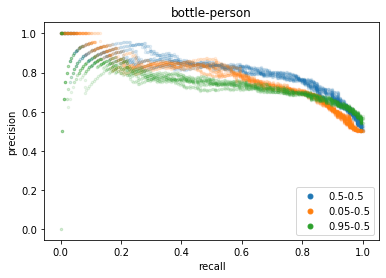

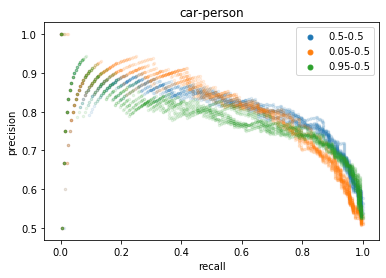

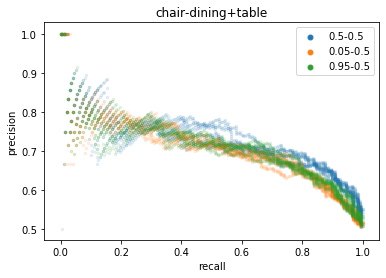

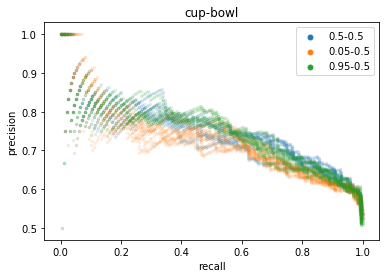

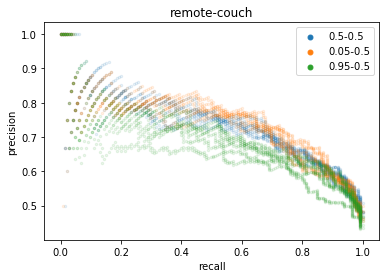

In [3]:
for pair in [('bottle', 'person'), ('car', 'person'), ('chair', 'dining+table'), ('cup', 'bowl'), ('remote', 'couch')]:
    plot(pair[0], pair[1])
